### 설정
1. 파이썬 3.10 이상 설치 (64 bit)
2. 가상환경 생성
3. 파일 경로 설정

In [55]:
import torch
import numpy as np
import cv2
from PIL import Image

print(f"PyTorch version: {torch.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"OpenCV version: {cv2.__version__}")

PyTorch version: 2.8.0+cpu
NumPy version: 2.2.6
OpenCV version: 4.12.0


In [56]:
import cv2
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import cv2
import json
import os
from tqdm import tqdm
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights
from torchvision.datasets import ImageFolder


In [57]:
image_path = "C:/소아복부합성데이터/Training/TS_1.질환_1.선천성유문협착증/1_0003.png"

# Read the file as a byte stream
try:
    with open(image_path, "rb") as f:
        bytes_data = f.read()
    
    # Convert the byte stream to a NumPy array
    np_array = np.frombuffer(bytes_data, dtype=np.uint8)

    # Use cv2.imdecode() to load the image from the NumPy array
    opencv_image = cv2.imdecode(np_array, cv2.IMREAD_COLOR)

    if opencv_image is not None:
        print(f"OpenCV로 이미지 불러오기 성공: {opencv_image.shape}")
    else:
        print("오류: OpenCV가 이미지를 불러오지 못했습니다. 파일이 손상되었거나 형식이 잘못되었습니다.")

except FileNotFoundError:
    print("오류: 파일 경로를 찾을 수 없습니다.")
except Exception as e:
    print(f"이미지를 불러오는 중 예상치 못한 오류 발생: {e}")

OpenCV로 이미지 불러오기 성공: (512, 512, 3)


In [58]:
import os
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision import transforms

# 기본 경로
base_dir = "C:/소아복부합성데이터/"

# 각 폴더 경로
train_image_dir = os.path.join(base_dir, "Training")
val_image_dir = os.path.join(base_dir, "Validation")

def count_images_in_dir(directory):
    """
    지정된 디렉터리 내의 모든 하위 폴더에 있는 이미지 파일의 총 개수를 계산합니다.
    """
    count = 0
    # 디렉터리 내의 모든 파일과 폴더를 순회
    for root, dirs, files in os.walk(directory):
        for file in files:
            # 이미지 확장자(jpg, jpeg, png 등)를 확인
            if file.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp')):
                count += 1
    return count

# 각 폴더의 이미지 개수 계산
num_train_images = count_images_in_dir(train_image_dir)
num_val_images = count_images_in_dir(val_image_dir)
total_images = num_train_images + num_val_images

print(f"Training 폴더의 총 이미지 개수: {num_train_images}장")
print(f"Validation 폴더의 총 이미지 개수: {num_val_images}장")
print(f"전체 데이터셋 총 개수: {total_images}장")

Training 폴더의 총 이미지 개수: 8000장
Validation 폴더의 총 이미지 개수: 1000장
전체 데이터셋 총 개수: 9000장


In [59]:
base_dir = "C:/소아복부합성데이터"

image_paths = []
labels = []

# os.walk를 사용하여 모든 하위 폴더를 탐색
for root, dirs, files in os.walk(base_dir):
    if 'TL_' in os.path.basename(root) or 'TS_' in os.path.basename(root):
        label_raw = os.path.basename(root)
        label = label_raw.replace('TL_', '').replace('TS_', '')
        
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_path = os.path.join(root, file)
                image_paths.append(image_path)
                labels.append(label)

df = pd.DataFrame({'image_path': image_paths, 'label': labels})

print(df.head())
print(f"총 이미지 개수: {len(df)}")
print(f"고유한 라벨(클래스) 개수: {df['label'].nunique()}개")
print(f"고유한 라벨 목록:\n{df['label'].unique()}")

                                          image_path            label
0  C:/소아복부합성데이터\Training\TS_1.질환_1.선천성유문협착증\1_000...  1.질환_1.선천성유문협착증
1  C:/소아복부합성데이터\Training\TS_1.질환_1.선천성유문협착증\1_000...  1.질환_1.선천성유문협착증
2  C:/소아복부합성데이터\Training\TS_1.질환_1.선천성유문협착증\1_000...  1.질환_1.선천성유문협착증
3  C:/소아복부합성데이터\Training\TS_1.질환_1.선천성유문협착증\1_000...  1.질환_1.선천성유문협착증
4  C:/소아복부합성데이터\Training\TS_1.질환_1.선천성유문협착증\1_001...  1.질환_1.선천성유문협착증
총 이미지 개수: 8000
고유한 라벨(클래스) 개수: 5개
고유한 라벨 목록:
['1.질환_1.선천성유문협착증' '1.질환_2.기복증' '1.질환_3.공기액체음영' '1.질환_4.변비' '2.정상']


In [ ]:
image_dir = "C:/소아복부합성데이터/Training/"
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [61]:
# 커스텀 데이터셋 클래스
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        
    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # DataFrame에서 이미지 경로와 라벨 경로 가져오기
        img_path = self.dataframe.iloc[idx]['image_path']
        label_path = self.dataframe.iloc[idx]['label_path']
        
        # 이미지 불러오기 (한글 경로 문제 해결 방식 사용)
        with open(img_path, "rb") as f:
            bytes_data = f.read()
        np_array = np.frombuffer(bytes_data, dtype=np.uint8)
        image = cv2.imdecode(np_array, cv2.IMREAD_COLOR)
        
        # BGR을 RGB로 변환 (OpenCV는 BGR, PyTorch는 RGB)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # JSON 라벨 불러오기
        with open(label_path, 'r', encoding='utf-8') as f:
            label_data = json.load(f)
            # 여기서는 'disease' 키에 정답이 있다고 가정
            label_id = label_data['patient']['diagnosis'] - 1
            
        # 전처리 적용
        if self.transform:
            image = self.transform(image)

        return image, label_id

In [62]:
# 수정된 CustomImageDataset 클래스 (권장)
class CustomImageDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        
        # 'label' 열이 있는지 확인하고 없으면 오류를 발생시킵니다.
        if 'label' not in self.df.columns:
            raise KeyError("DataFrame must contain a 'label' column.")

        # 이미지 경로와 라벨 열을 명시적으로 지정합니다.
        self.image_paths = self.df['image_path'].values
        self.labels = self.df['label'].values

        # 라벨을 숫자로 매핑합니다.
        self.label_to_idx = {label: i for i, label in enumerate(self.df['label'].unique())}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df['image_path'][idx]
        label = self.df['label'][idx]
        
        image = Image.open(image_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
            
        # 라벨을 숫자로 변환하여 반환합니다.
        return image, self.label_to_idx[label]

In [63]:
full_df = pd.DataFrame({'image_path': image_paths, 'label': labels})

# 3. 데이터셋 분할 및 DataLoader 생성
# 전체 데이터셋을 Training, Validation, Test 세트로 나눕니다.
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

full_dataset = CustomImageDataset(full_df, transform=transform)

# 전체 데이터셋을 8:1:1 비율로 나눕니다.
total_size = len(full_dataset)
train_size = int(total_size * 0.8)
val_size = int(total_size * 0.1)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

print(f"Total dataset size: {total_size}장")
print(f"Training set size: {len(train_dataset)}장")
print(f"Validation set size: {len(val_dataset)}장")
print(f"Test set size: {len(test_dataset)}장")

# DataLoader 생성
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print("DataLoader 생성이 완료되었습니다.")

Total dataset size: 8000장
Training set size: 6400장
Validation set size: 800장
Test set size: 800장
DataLoader 생성이 완료되었습니다.


In [64]:
device = torch.device("cpu")

# ResNet-34 모델 불러오기
model = models.resnet34(pretrained=True)
#model = convnext_tiny(weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1)
num_classes = 5 
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

c:\Ai_project(2)\my_ai_project_cpu\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Ai_project(2)\my_ai_project_cpu\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [65]:
class EarlyStopping:
    """검증 손실이 개선되지 않으면 학습을 중단하는 클래스"""
    def __init__(self, patience=5, verbose=False, delta=0):
        """
        Args:
            patience (int): 검증 손실이 개선되지 않을 때 대기할 에폭(epoch) 수
                            기본값: 5
            verbose (bool): True이면 검증 손실이 개선될 때마다 메시지를 출력
                            기본값: False
            delta (float): 개선되었다고 판단하는 최소 변화량.
                           기본값: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta

    def __call__(self, val_loss, model):
        """
        Args:
            val_loss (float): 현재 검증 손실
            model (torch.nn.Module): 현재 모델
        """
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """검증 손실이 감소하면 모델을 저장합니다."""
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

In [66]:
print(df.head())


                                          image_path            label
0  C:/소아복부합성데이터\Training\TS_1.질환_1.선천성유문협착증\1_000...  1.질환_1.선천성유문협착증
1  C:/소아복부합성데이터\Training\TS_1.질환_1.선천성유문협착증\1_000...  1.질환_1.선천성유문협착증
2  C:/소아복부합성데이터\Training\TS_1.질환_1.선천성유문협착증\1_000...  1.질환_1.선천성유문협착증
3  C:/소아복부합성데이터\Training\TS_1.질환_1.선천성유문협착증\1_000...  1.질환_1.선천성유문협착증
4  C:/소아복부합성데이터\Training\TS_1.질환_1.선천성유문협착증\1_001...  1.질환_1.선천성유문협착증


In [ ]:
early_stopping = EarlyStopping(patience=5, verbose=True)
num_epochs = 1000

for epoch in range(num_epochs):
    # 훈련 단계
    model.train()
    running_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [TRAIN]", leave=True)
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        pbar.set_postfix({'loss': running_loss / (pbar.n + 1)})

    # 검증 단계
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        pbar_val = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [VALID]", leave=True)
        for inputs, labels in pbar_val:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            pbar_val.set_postfix({'val_loss': val_loss / (pbar_val.n + 1)})
    
    avg_val_loss = val_loss / len(val_loader)
    
    # EarlyStopping 호출
    early_stopping(avg_val_loss, model)
    
    # 조기 종료 확인
    if early_stopping.early_stop:
        print("Early stopping triggered. Terminating training.")
        break
        
    accuracy = (correct / total) * 100
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {running_loss/len(train_loader):.4f}, Val Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.2f}%")

### 과적합 문제 발생 (이슈발생 : 250923)
시도 1. 조기종료
시도 2. 데이터 증강

### 에폭 2 데이터셋 점검 필요 (이슈발생:250923)
- 원인 : 이전 학습 세션에서 캐시된 데이터나 일시적인 시스템 오류
- 해결 : 코드를 재실행하고 데이터를 다시 로드

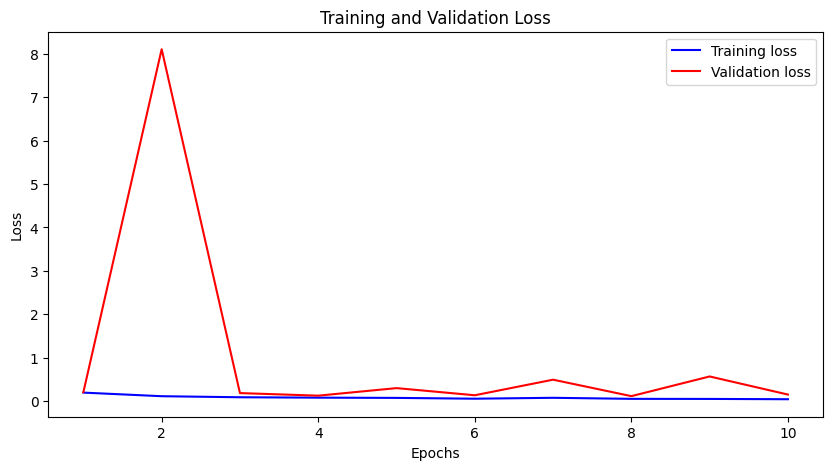

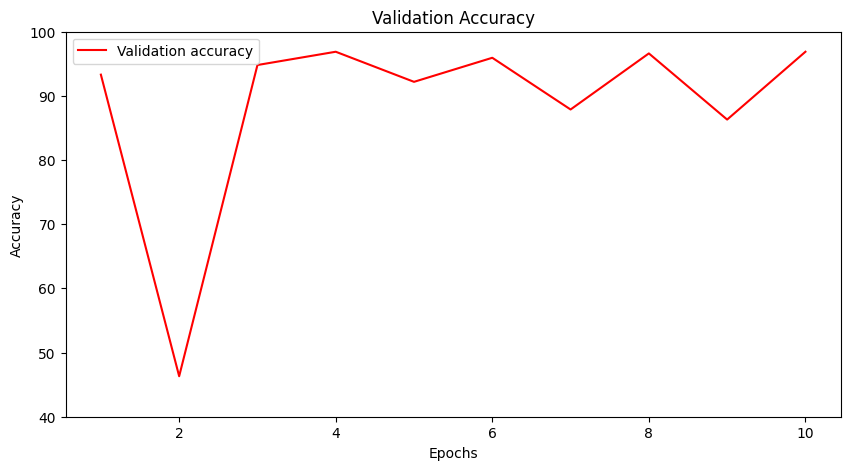

In [ ]:
import matplotlib.pyplot as plt

# 예시 데이터 (사용자 제공 로그에서 추출)
# 이 리스트에 각 Epoch의 데이터를 저장해야 합니다.
train_losses = [0.1916, 0.1086, 0.0844, 0.0752, 0.0697, 0.0511, 0.0719, 0.0477, 0.0459, 0.0391]
val_losses = [0.2017, 8.1095, 0.1805, 0.1211, 0.2952, 0.1304, 0.4896, 0.1100, 0.5639, 0.1468]
train_accuracies = [None] * 10  # 훈련 정확도 로그가 없으므로 None으로 처리
val_accuracies = [93.31, 46.31, 94.81, 96.88, 92.19, 95.94, 87.88, 96.62, 86.31, 96.88]

epochs = range(1, 11)

# Loss 그래프
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy 그래프
plt.figure(figsize=(10, 5))
# plt.plot(epochs, train_accuracies, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim(40, 100)  # y축 범위를 40%에서 100%로 설정하여 변화를 더 잘 보이게 함
plt.show()